<a href="https://colab.research.google.com/github/a-donat/InProgress/blob/main/Classify_LTV_Tier_Customers_w_Two_Policies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Load Libraries and Download Data

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d ranja7/vehicle-insurance-customer-data
! unzip '/content/vehicle-insurance-customer-data.zip' -d '/content/data'

In [ ]:
! pip install mlinsights
! unzip '/content/Relationships' -d '/content/'

In [ ]:
! pip install pycaret

In [ ]:
! pip uninstall scipy -y
! pip install scipy
! pip uninstall yellowbrick -y
! pip install yellowbrick

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import sys
import importlib
from typing import *
from sklearn.model_selection import train_test_split

In [23]:
# from pycaret.classification import * throws an error
from pycaret.classification import setup, compare_models, plot_model, \
create_model, tune_model, blend_models, predict_model, finalize_model

In [2]:
from pycaret.classification import *

# II. Data Preprocessing

In [3]:
ltv_df = pd.read_csv("/content/data/AutoInsurance.csv")

In [4]:
ltv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

In [5]:
ltv_df["Effective To Date"] = pd.to_datetime(ltv_df["Effective To Date"])
ltv_df["Effective To Date"] = (
    ltv_df["Effective To Date"] - ltv_df["Effective To Date"].min()).dt.days
ltv_df["Policy Level"] = ltv_df["Policy"].str.split("\s+", expand=True)[1]

In [6]:
ltv_df["vehicle class group"] = ltv_df["Vehicle Class"].map({
    "Two-Door Car": "A", "Sports Car": "B", "Four-Door Car": "A", "SUV": "B",
    "Luxury SUV": "C", "Luxury Car": "C"})

In [7]:
ltv_df["Is_Tier_3"] = (
    ltv_df["Customer Lifetime Value"] <= (
        ltv_df["Monthly Premium Auto"]*120 + 600)
    ).astype(int)

In [8]:
ltv_train, ltv_test = train_test_split(ltv_df, test_size=.15, random_state=1)

In [9]:
del ltv_df

In [10]:
ltv_train = ltv_train[ltv_train["Number of Policies"] == 2].copy()
ltv_test = ltv_test[ltv_test["Number of Policies"] == 2].copy()


In [11]:
print(ltv_train.shape)
print(ltv_test.shape)

(1948, 27)
(346, 27)


In [12]:
print(ltv_train["Is_Tier_3"].mean())
print(ltv_test["Is_Tier_3"].mean())

0.5893223819301848
0.6329479768786127


# III. Machine Learning Models

In [13]:
ltv_models = setup(
    data=ltv_train, target = "Is_Tier_3", fix_imbalance=True,
    ignore_features=[
        "Customer", "Number of Policies", "Customer Lifetime Value"],
    session_id=123)


,Description,Value
0,Session id,123
1,Target,Is_Tier_3
2,Target type,Binary
3,Original data shape,"(1948, 27)"
4,Transformed data shape,"(2191, 69)"
5,Transformed train set shape,"(1606, 69)"
6,Transformed test set shape,"(585, 69)"
7,Ignore features,3
8,Ordinal features,2
9,Numeric features,7


In [14]:
best_model = compare_models(fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6119,0.6073,0.7833,0.6390,0.7037,0.1573,0.1651,0.8360
lightgbm,Light Gradient Boosting Machine,0.5848,0.5948,0.7074,0.6317,0.6672,0.1195,0.1211,1.8640
gbc,Gradient Boosting Classifier,0.5840,0.5804,0.7422,0.6236,0.6776,0.1036,0.1067,0.8920
et,Extra Trees Classifier,0.5825,0.5915,0.7260,0.6255,0.6719,0.1066,0.1091,1.1060
dt,Decision Tree Classifier,0.5730,0.5644,0.6126,0.6445,0.6280,0.1275,0.1277,0.3580
xgboost,Extreme Gradient Boosting,0.5723,0.6009,0.6887,0.6243,0.6548,0.0961,0.0970,0.6640
ada,Ada Boost Classifier,0.5657,0.5459,0.6900,0.6176,0.6514,0.0795,0.0806,0.5220
knn,K Neighbors Classifier,0.5642,0.5641,0.5927,0.6417,0.6158,0.1138,0.1147,0.6360
ridge,Ridge Classifier,0.5547,0.0000,0.5754,0.6351,0.6029,0.0983,0.0993,0.3380
lda,Linear Discriminant Analysis,0.5547,0.5609,0.5741,0.6356,0.6024,0.0987,0.0998,0.4020


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [15]:
rf = create_model("rf")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6277,0.6159,0.8025,0.6500,0.7182,0.1873,0.1965
1,0.6131,0.5753,0.8395,0.6296,0.7196,0.1353,0.1507
2,0.5839,0.5633,0.7407,0.6250,0.6780,0.1021,0.1051
3,0.5882,0.5948,0.7750,0.6200,0.6889,0.1019,0.1076
4,0.5809,0.6427,0.7500,0.6186,0.6780,0.0935,0.0972
5,0.6103,0.6366,0.7750,0.6392,0.7006,0.1572,0.1632
6,0.6544,0.6136,0.8000,0.6737,0.7314,0.2567,0.2643
7,0.6176,0.7007,0.7625,0.6489,0.7011,0.1800,0.1845
8,0.6471,0.6795,0.8125,0.6633,0.7303,0.2345,0.2448


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

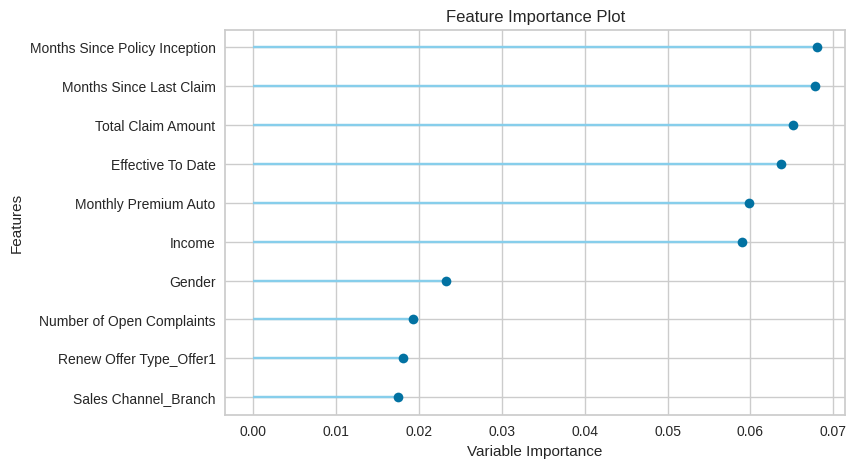

In [16]:
plot_model(rf, plot="feature")

In [17]:
tuned_rf = tune_model(rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5912,0.5223,0.8642,0.6087,0.7143,0.0669,0.0812
1,0.6058,0.5015,0.8642,0.6195,0.7216,0.1057,0.1246
2,0.6423,0.5816,0.8395,0.6538,0.7351,0.2100,0.2261
3,0.5809,0.5641,0.8000,0.6095,0.6919,0.0727,0.0796
4,0.6103,0.5835,0.8375,0.6262,0.7166,0.1328,0.1481
5,0.6176,0.6319,0.8375,0.6321,0.7204,0.1516,0.1674
6,0.5735,0.5893,0.8625,0.5948,0.7041,0.0257,0.0323
7,0.5882,0.6973,0.8750,0.6034,0.7143,0.0593,0.0744
8,0.6397,0.6759,0.8875,0.6396,0.7435,0.1889,0.2201


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [18]:
dt = create_model("dt")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5839,0.5627,0.6790,0.6395,0.6587,0.1272,0.1276
1,0.5109,0.4927,0.5926,0.5854,0.5890,-0.0146,-0.0146
2,0.5109,0.5010,0.5556,0.5921,0.5732,0.0020,0.0020
3,0.5294,0.5170,0.5875,0.6026,0.5949,0.0337,0.0338
4,0.6250,0.6196,0.6500,0.6933,0.6710,0.2361,0.2368
5,0.5368,0.5312,0.5625,0.6164,0.5882,0.0613,0.0617
6,0.5221,0.5000,0.6250,0.5882,0.6061,0.0000,0.0000
7,0.5956,0.5786,0.6750,0.6506,0.6626,0.1584,0.1586
8,0.5074,0.5062,0.5125,0.5942,0.5503,0.0121,0.0123


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [19]:
tuned_dt = tune_model(dt)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5328,0.5311,0.6667,0.5934,0.6279,0.0061,0.0062
1,0.5547,0.4754,0.7407,0.6000,0.6630,0.0279,0.0293
2,0.5182,0.5267,0.5679,0.5974,0.5823,0.0142,0.0142
3,0.5588,0.5456,0.7750,0.5962,0.6739,0.0267,0.0290
4,0.6471,0.6415,0.7250,0.6905,0.7073,0.2635,0.2640
5,0.5809,0.5590,0.7250,0.6237,0.6705,0.1036,0.1058
6,0.5809,0.5257,0.7375,0.6211,0.6743,0.0986,0.1015
7,0.5809,0.5143,0.8250,0.6055,0.6984,0.0620,0.0705
8,0.6397,0.6169,0.6750,0.7013,0.6879,0.2622,0.2624


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [20]:
tuned_dt

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=6, max_features=1.0, max_leaf_nodes=None,
                       min_impurity_decrease=0.002, min_samples_leaf=5,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       random_state=123, splitter='best')

In [21]:
knn = create_model("knn")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6277,0.6533,0.7037,0.6786,0.6909,0.2234,0.2236
1,0.5985,0.5576,0.6543,0.6625,0.6584,0.1717,0.1717
2,0.5839,0.5890,0.5802,0.6714,0.6225,0.1645,0.1667
3,0.5074,0.5217,0.5375,0.5890,0.5621,0.0018,0.0018
4,0.5000,0.5151,0.5500,0.5789,0.5641,-0.0212,-0.0212
5,0.5147,0.5540,0.6000,0.5854,0.5926,-0.0072,-0.0072
6,0.5441,0.5737,0.5000,0.6452,0.5634,0.1022,0.1059
7,0.6103,0.5677,0.6250,0.6849,0.6536,0.2103,0.2115
8,0.5956,0.6060,0.6000,0.6761,0.6358,0.1848,0.1865


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [22]:
tuned_knn = tune_model(knn)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6569,0.6962,0.7407,0.6977,0.7186,0.2803,0.2811
1,0.5839,0.6070,0.6173,0.6579,0.6369,0.1509,0.1513
2,0.5328,0.5913,0.5679,0.6133,0.5897,0.0492,0.0494
3,0.5368,0.5956,0.5500,0.6197,0.5828,0.0663,0.0669
4,0.5441,0.5566,0.5875,0.6184,0.6026,0.0689,0.0690
5,0.4926,0.5634,0.6000,0.5647,0.5818,-0.0615,-0.0617
6,0.5662,0.6150,0.5125,0.6721,0.5816,0.1478,0.1537
7,0.6103,0.6494,0.6375,0.6800,0.6581,0.2062,0.2067
8,0.6103,0.6627,0.6375,0.6800,0.6581,0.2062,0.2067


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


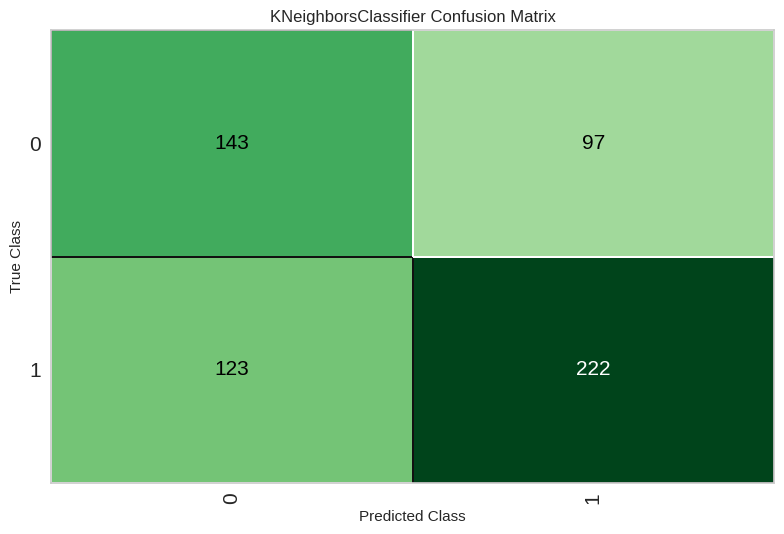

In [23]:
plot_model(tuned_knn, plot = 'confusion_matrix')


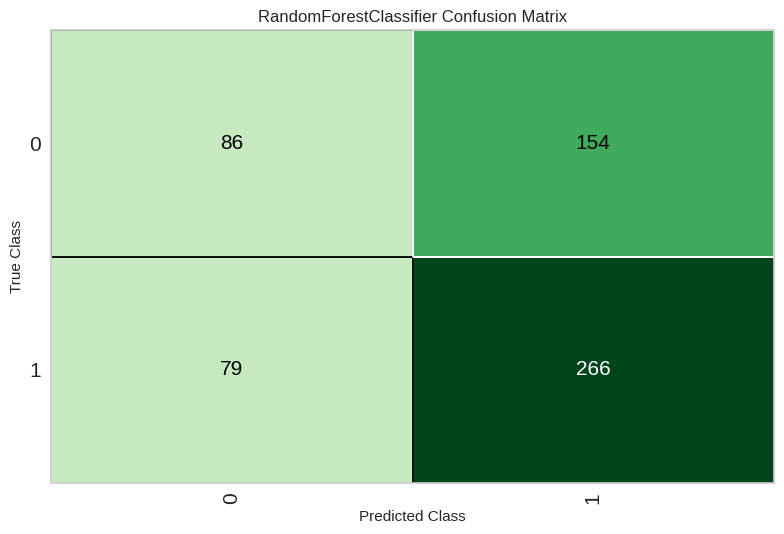

In [24]:
plot_model(rf, plot = 'confusion_matrix')


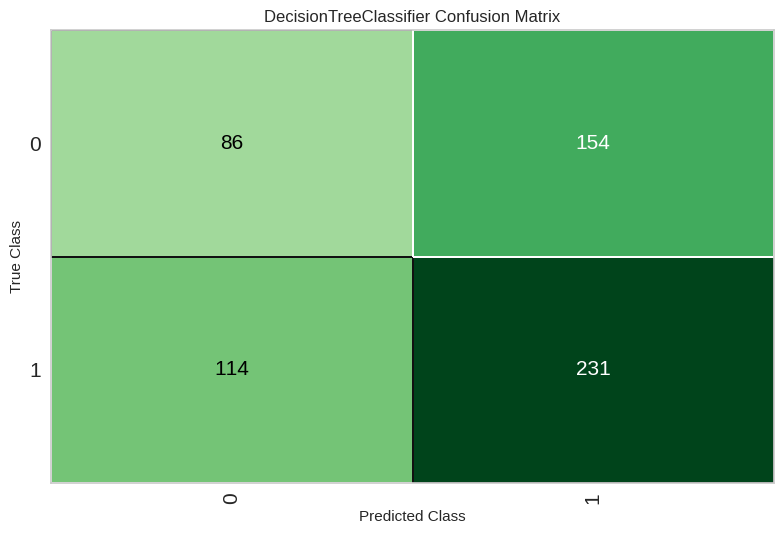

In [26]:
plot_model(tuned_dt, plot = 'confusion_matrix')


In [27]:
blended_pretuned = blend_models([rf, tuned_dt, tuned_knn])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6204,0.6495,0.7901,0.6465,0.7111,0.1737,0.1813
1,0.5693,0.5529,0.7284,0.6146,0.6667,0.0706,0.0727
2,0.5620,0.5796,0.7407,0.6061,0.6667,0.0466,0.0487
3,0.5368,0.5812,0.6500,0.5977,0.6228,0.0255,0.0256
4,0.6544,0.6587,0.7875,0.6774,0.7283,0.2609,0.2665
5,0.5221,0.5766,0.6875,0.5789,0.6286,-0.0279,-0.0287
6,0.5882,0.5917,0.6625,0.6463,0.6543,0.1454,0.1455
7,0.6250,0.6795,0.7875,0.6495,0.7119,0.1890,0.1963
8,0.6618,0.7013,0.7250,0.7073,0.7160,0.2980,0.2982


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

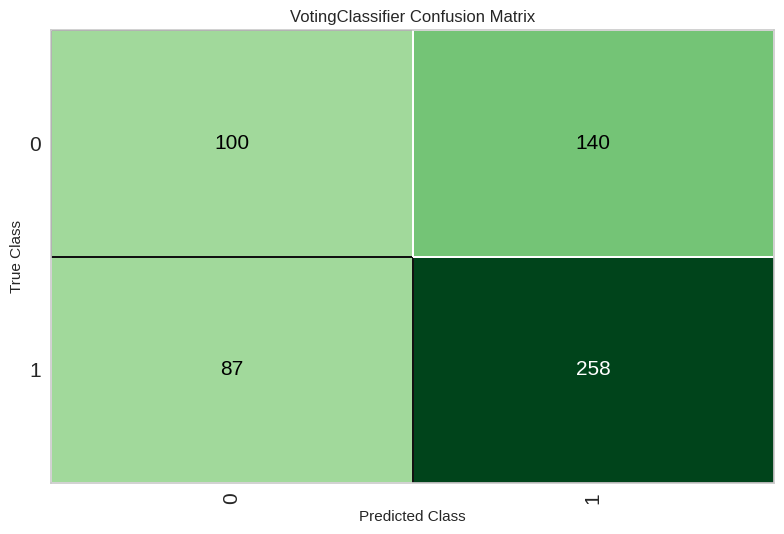

In [30]:
plot_model(blended_pretuned, plot="confusion_matrix")


In [31]:
blended_pretuned_tuned = tune_model(blended_pretuned)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6569,0.6219,0.8765,0.6574,0.7513,0.2332,0.2597
1,0.5839,0.5256,0.7778,0.6176,0.6885,0.0863,0.0917
2,0.6058,0.5569,0.7654,0.6392,0.6966,0.1469,0.1518
3,0.5441,0.5786,0.7125,0.5938,0.6477,0.0168,0.0174
4,0.7059,0.6911,0.8500,0.7083,0.7727,0.3657,0.3780
5,0.6029,0.5944,0.8250,0.6226,0.7097,0.1190,0.1314
6,0.6103,0.5701,0.8000,0.6337,0.7072,0.1476,0.1568
7,0.6618,0.6654,0.8500,0.6667,0.7473,0.2581,0.2760
8,0.6691,0.7009,0.7500,0.7059,0.7273,0.3077,0.3086


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


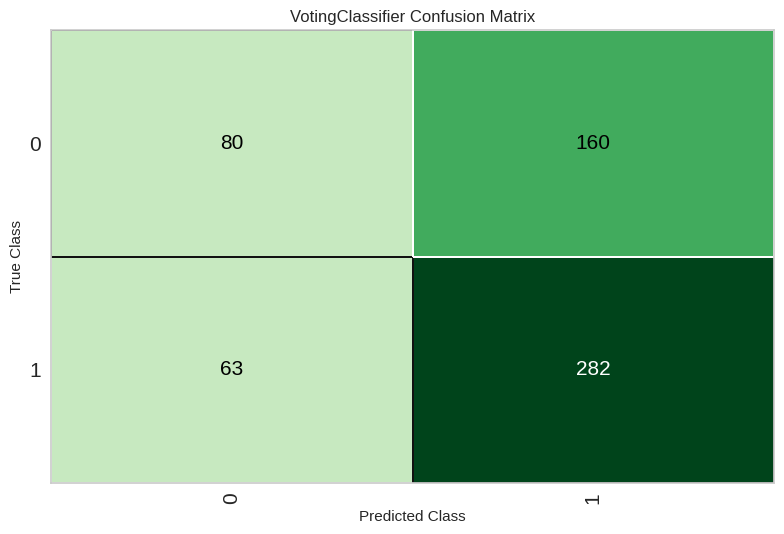

In [32]:
plot_model(blended_pretuned_tuned, plot="confusion_matrix")


In [33]:
blended_untuned = blend_models([rf, dt, knn])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5985,0.6322,0.7037,0.6477,0.6746,0.1531,0.1540
1,0.5182,0.5214,0.6173,0.5882,0.6024,-0.0078,-0.0078
2,0.5109,0.5558,0.6049,0.5833,0.5939,-0.0202,-0.0203
3,0.5368,0.5407,0.6125,0.6049,0.6087,0.0412,0.0412
4,0.6471,0.6368,0.6750,0.7105,0.6923,0.2792,0.2797
5,0.5515,0.5727,0.5875,0.6267,0.6065,0.0863,0.0866
6,0.5221,0.5433,0.6125,0.5904,0.6012,0.0054,0.0054
7,0.6176,0.6355,0.7125,0.6628,0.6867,0.1978,0.1987
8,0.5221,0.5750,0.5125,0.6119,0.5578,0.0466,0.0475


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

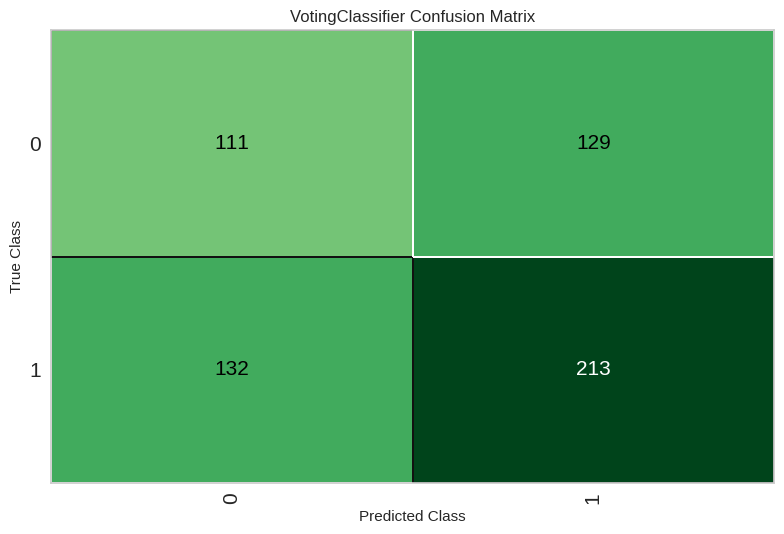

In [34]:
plot_model(blended_untuned, plot="confusion_matrix")


In [35]:
blended_untuned_tuned = tune_model(blended_untuned)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6131,0.6407,0.7531,0.6489,0.6971,0.1699,0.1735
1,0.5255,0.5302,0.6296,0.5930,0.6108,0.0047,0.0047
2,0.5255,0.5686,0.6173,0.5952,0.6061,0.0102,0.0102
3,0.5368,0.5432,0.6125,0.6049,0.6087,0.0412,0.0412
4,0.6250,0.6307,0.6625,0.6883,0.6752,0.2321,0.2323
5,0.5368,0.5728,0.5750,0.6133,0.5935,0.0564,0.0565
6,0.5368,0.5564,0.6500,0.5977,0.6228,0.0255,0.0256
7,0.6103,0.6373,0.7125,0.6552,0.6826,0.1802,0.1812
8,0.5588,0.5929,0.5500,0.6471,0.5946,0.1176,0.1195


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [36]:
pred_holdout_bpp = predict_model(blended_pretuned_tuned)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.6188,0.6242,0.8174,0.6380,0.7166,0.1606,0.1725


In [39]:
pred_train_bpp = predict_model(blended_pretuned_tuned, data=ltv_train)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8855,0.9532,0.9451,0.8715,0.9068,0.7591,0.7633


In [40]:
pred_test_bpp = predict_model(blended_pretuned_tuned, data = ltv_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.5954,0.6046,0.7260,0.6653,0.6943,0.0994,0.1002


In [38]:
pred_holdout_bpp.shape

(585, 26)

In [41]:
pred_holdout_rf = predict_model(rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.6017,0.6053,0.7710,0.6333,0.6954,0.1358,0.1414


In [42]:
pred_train_rf = predict_model(rf, data=ltv_train)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8804,0.9636,0.9312,0.8741,0.9017,0.7493,0.7518


In [43]:
pred_test_rf = predict_model(rf, data=ltv_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.6185,0.6363,0.7443,0.6820,0.7118,0.1509,0.1521


In [44]:
pred_train_rf["ltv_mpa_ratio"] = (
  pred_train_rf["Customer Lifetime Value"] - 600)/(
      pred_train_rf["Monthly Premium Auto"])

In [55]:
pred_test_rf["ltv_mpa_ratio"] = (
  pred_test_rf["Customer Lifetime Value"] - 600)/(
      pred_test_rf["Monthly Premium Auto"])

pred_train_bpp["ltv_mpa_ratio"] = (
  pred_train_bpp["Customer Lifetime Value"] - 600)/(
      pred_train_bpp["Monthly Premium Auto"])

pred_test_bpp["ltv_mpa_ratio"] = (
  pred_test_bpp["Customer Lifetime Value"] - 600)/(
      pred_test_bpp["Monthly Premium Auto"])

In [45]:
list(pred_train_rf)

['Customer',
 'State',
 'Customer Lifetime Value',
 'Response',
 'Coverage',
 'Education',
 'Effective To Date',
 'EmploymentStatus',
 'Gender',
 'Income',
 'Location Code',
 'Marital Status',
 'Monthly Premium Auto',
 'Months Since Last Claim',
 'Months Since Policy Inception',
 'Number of Open Complaints',
 'Number of Policies',
 'Policy Type',
 'Policy',
 'Renew Offer Type',
 'Sales Channel',
 'Total Claim Amount',
 'Vehicle Class',
 'Vehicle Size',
 'Policy Level',
 'vehicle class group',
 'Is_Tier_3',
 'prediction_label',
 'prediction_score',
 'ltv_mpa_ratio']

In [47]:
pred_train_rf[
    ["Customer Lifetime Value", "ltv_mpa_ratio", 'prediction_label', "prediction_score"]
    ].corr().round(2)

,Customer Lifetime Value,ltv_mpa_ratio,prediction_label,prediction_score
Customer Lifetime Value,1.00,0.77,-0.49,-0.11
ltv_mpa_ratio,0.77,1.00,-0.63,-0.10
prediction_label,-0.49,-0.63,1.00,0.06
prediction_score,-0.11,-0.10,0.06,1.00


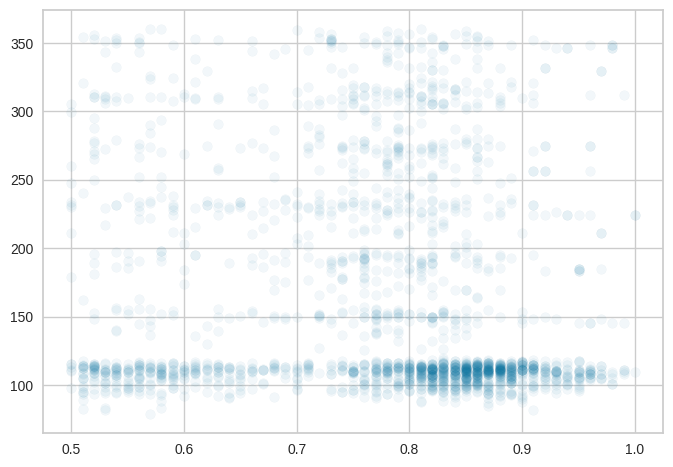

In [48]:
plt.scatter(pred_train_rf["prediction_score"], pred_train_rf["ltv_mpa_ratio"], alpha=.05)

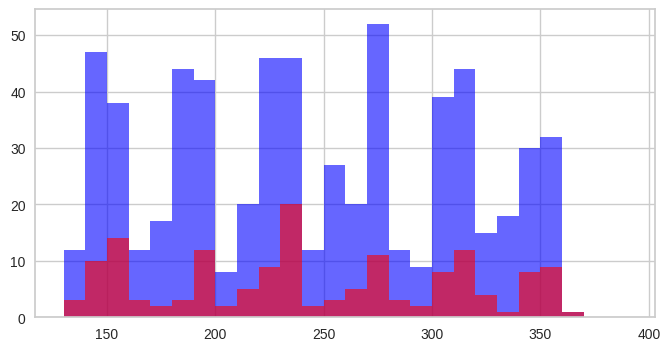

In [53]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(pred_train_rf[pred_train_rf["prediction_label"]==0]["ltv_mpa_ratio"],
        bins=np.arange(130, 400, 10),
        alpha=.6, color="blue")
ax.hist(pred_train_rf[pred_train_rf["prediction_label"]==1]["ltv_mpa_ratio"],
        bins=np.arange(130, 400, 10),
        alpha=.6, color="red")
plt.show()

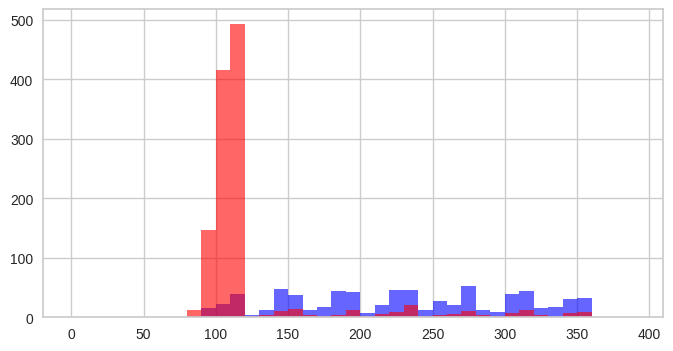

In [52]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(pred_train_rf[pred_train_rf["prediction_label"]==0]["ltv_mpa_ratio"],
        bins=np.arange(0, 400, 10),
        alpha=.6, color="blue")
ax.hist(pred_train_rf[pred_train_rf["prediction_label"]==1]["ltv_mpa_ratio"],
        bins=np.arange(0, 400, 10),
        alpha=.6, color="red")
plt.show()

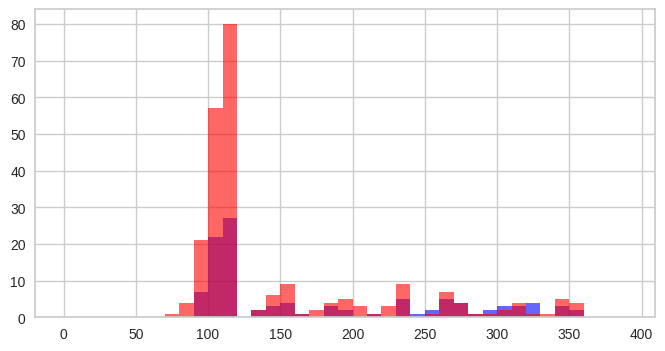

In [56]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(pred_test_rf[pred_test_rf["prediction_label"]==0]["ltv_mpa_ratio"],
        bins=np.arange(0, 400, 10),
        alpha=.6, color="blue")
ax.hist(pred_test_rf[pred_test_rf["prediction_label"]==1]["ltv_mpa_ratio"],
        bins=np.arange(0, 400, 10),
        alpha=.6, color="red")
plt.show()

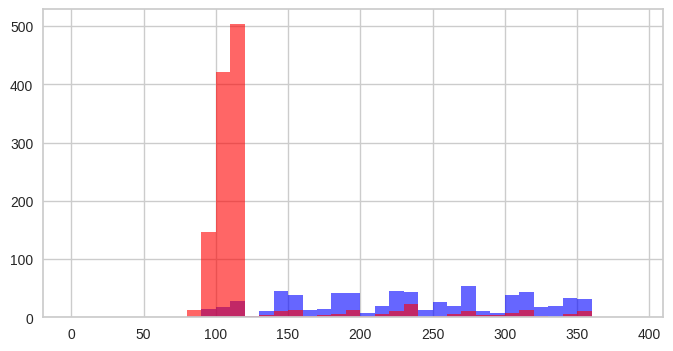

In [57]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(pred_train_bpp[pred_train_bpp["prediction_label"]==0]["ltv_mpa_ratio"],
        bins=np.arange(0, 400, 10),
        alpha=.6, color="blue")
ax.hist(pred_train_bpp[pred_train_bpp["prediction_label"]==1]["ltv_mpa_ratio"],
        bins=np.arange(0, 400, 10),
        alpha=.6, color="red")
plt.show()

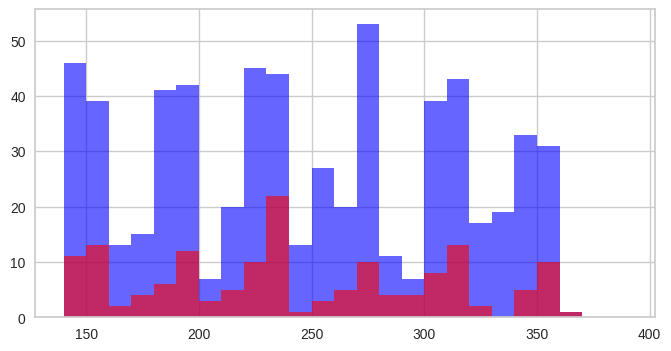

In [58]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(pred_train_bpp[pred_train_bpp["prediction_label"]==0]["ltv_mpa_ratio"],
        bins=np.arange(140, 400, 10),
        alpha=.6, color="blue")
ax.hist(pred_train_bpp[pred_train_bpp["prediction_label"]==1]["ltv_mpa_ratio"],
        bins=np.arange(140, 400, 10),
        alpha=.6, color="red")
plt.show()

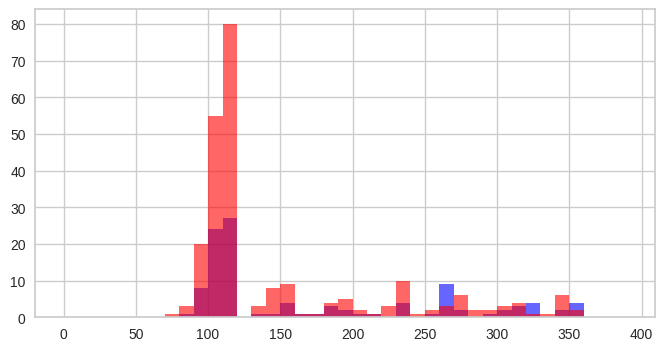

In [62]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(pred_test_bpp[pred_test_bpp["prediction_label"]==0]["ltv_mpa_ratio"],
        bins=np.arange(0, 400, 10),
        alpha=.6, color="blue")
ax.hist(pred_test_bpp[pred_test_bpp["prediction_label"]==1]["ltv_mpa_ratio"],
        bins=np.arange(0, 400, 10),
        alpha=.6, color="red")
plt.show()

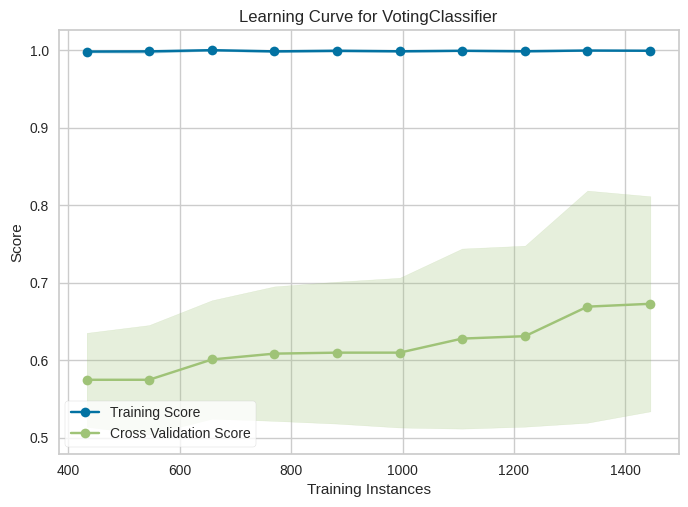

In [60]:
plot_model(blended_pretuned_tuned, plot="learning")

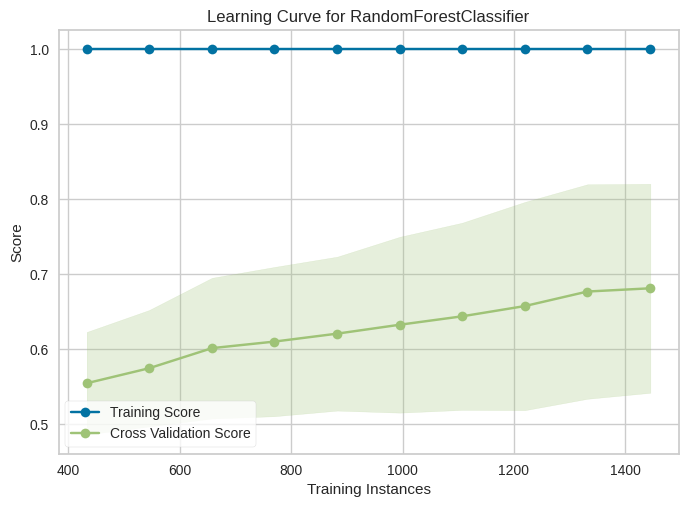

In [61]:
plot_model(rf, plot="learning")

In [63]:
final_blended = finalize_model(blended_pretuned_tuned)


In [64]:
final_rf = finalize_model(rf)

In [65]:
save_model(final_blended, "blended_model_binary_tier_ltv_2policies")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Effective To Date', 'Income',
                                              'Monthly Premium Auto',
                                              'Months Since Last Claim',
                                              'Months Since Policy Inception',
                                              'Number of Open Complaints',
                                              'Total Claim Amount'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,...
                                                                       min_samples_split=5,
    

In [68]:
save_model(final_rf, "rf_tier_ltv_2policies")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Effective To Date', 'Income',
                                              'Monthly Premium Auto',
                                              'Months Since Last Claim',
                                              'Months Since Policy Inception',
                                              'Number of Open Complaints',
                                              'Total Claim Amount'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                        

Categorical Variables Only:

In [69]:
list(ltv_train.corr())

['Customer Lifetime Value',
 'Effective To Date',
 'Income',
 'Monthly Premium Auto',
 'Months Since Last Claim',
 'Months Since Policy Inception',
 'Number of Open Complaints',
 'Number of Policies',
 'Total Claim Amount',
 'Is_Tier_3']

In [70]:
ltv_cat_models = setup(
    data=ltv_train, target = "Is_Tier_3", fix_imbalance=True,
    ignore_features=[
        'Customer', 'Customer Lifetime Value', 'Effective To Date', 'Income',
        'Monthly Premium Auto', 'Months Since Last Claim',
        'Months Since Policy Inception', 'Number of Open Complaints',
        'Number of Policies', 'Total Claim Amount',], session_id=123)

,Description,Value
0,Session id,123
1,Target,Is_Tier_3
2,Target type,Binary
3,Original data shape,"(1948, 27)"
4,Transformed data shape,"(2191, 62)"
5,Transformed train set shape,"(1606, 62)"
6,Transformed test set shape,"(585, 62)"
7,Ignore features,10
8,Ordinal features,2
9,Categorical features,16


In [71]:
best_cat_model = compare_models(fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.5899,0.5886,0.7211,0.6336,0.6744,0.1266,0.1285,0.6820
gbc,Gradient Boosting Classifier,0.5847,0.5626,0.7397,0.6247,0.6771,0.1065,0.1097,0.6160
rf,Random Forest Classifier,0.5825,0.5884,0.7447,0.6216,0.6776,0.0990,0.1023,0.7760
lightgbm,Light Gradient Boosting Machine,0.5811,0.5808,0.6937,0.6316,0.6610,0.1158,0.1167,1.9380
xgboost,Extreme Gradient Boosting,0.5752,0.5756,0.6862,0.6275,0.6552,0.1045,0.1055,0.5020
svm,SVM - Linear Kernel,0.5561,0.0000,0.6318,0.6215,0.6045,0.0812,0.0838,0.6500
dt,Decision Tree Classifier,0.5532,0.5414,0.6078,0.6248,0.6159,0.0820,0.0822,0.3500
ada,Ada Boost Classifier,0.5480,0.5466,0.6488,0.6095,0.6284,0.0530,0.0532,0.4460
ridge,Ridge Classifier,0.5393,0.0000,0.5567,0.6220,0.5874,0.0693,0.0699,0.6120
lda,Linear Discriminant Analysis,0.5385,0.5523,0.5567,0.6211,0.5870,0.0676,0.0682,0.5580


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [72]:
rf_cat = create_model("rf")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5766,0.5556,0.7778,0.6117,0.6848,0.0676,0.0723
1,0.5985,0.5938,0.7531,0.6354,0.6893,0.1336,0.1375
2,0.5912,0.5564,0.7160,0.6374,0.6744,0.1304,0.1320
3,0.5809,0.5955,0.7250,0.6237,0.6705,0.1036,0.1058
4,0.5294,0.5698,0.6750,0.5870,0.6279,-0.0037,-0.0038
5,0.6324,0.6503,0.7750,0.6596,0.7126,0.2115,0.2169
6,0.5809,0.5978,0.7625,0.6162,0.6816,0.0884,0.0928
7,0.6471,0.6943,0.7625,0.6778,0.7176,0.2514,0.2545
8,0.6250,0.6048,0.7625,0.6559,0.7052,0.1980,0.2022


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [73]:
tuned_rf_cat = tune_model(rf_cat)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5839,0.4925,0.7901,0.6154,0.6919,0.0810,0.0872
1,0.5474,0.4982,0.7531,0.5922,0.6630,0.0033,0.0035
2,0.5766,0.5626,0.7160,0.6237,0.6667,0.0942,0.0959
3,0.5074,0.4967,0.6250,0.5747,0.5988,-0.0364,-0.0366
4,0.5956,0.6071,0.7125,0.6404,0.6746,0.1446,0.1460
5,0.6250,0.6038,0.7500,0.6593,0.7018,0.2024,0.2055
6,0.5662,0.5815,0.7500,0.6061,0.6704,0.0564,0.0592
7,0.6324,0.6703,0.7875,0.6562,0.7159,0.2071,0.2141
8,0.6250,0.5596,0.7625,0.6559,0.7052,0.1980,0.2022


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


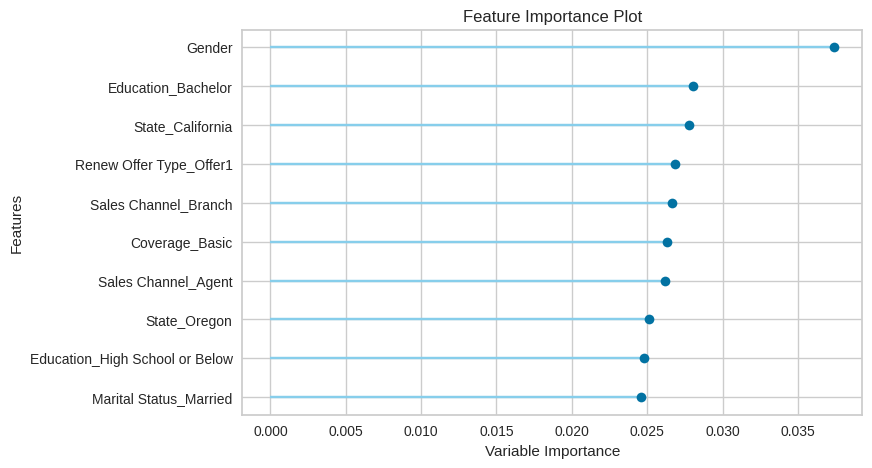

In [75]:
plot_model(rf_cat, "feature")

In [76]:
et_cat = create_model("et")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5985,0.5699,0.7778,0.6300,0.6961,0.1235,0.1296
1,0.5693,0.5615,0.7037,0.6196,0.6590,0.0812,0.0824
2,0.5328,0.5305,0.6543,0.5955,0.6235,0.0117,0.0118
3,0.5809,0.5672,0.7250,0.6237,0.6705,0.1036,0.1058
4,0.6176,0.6223,0.7250,0.6591,0.6905,0.1934,0.1949
5,0.6029,0.6190,0.6750,0.6585,0.6667,0.1759,0.1760
6,0.5882,0.5741,0.7750,0.6200,0.6889,0.1019,0.1076
7,0.5809,0.6498,0.6750,0.6353,0.6545,0.1231,0.1234
8,0.5515,0.5958,0.6375,0.6145,0.6258,0.0666,0.0667


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [77]:
tuned_et_cat = tune_model(et_cat)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5474,0.5311,0.6790,0.6044,0.6395,0.0372,0.0376
1,0.5620,0.4932,0.7654,0.6019,0.6739,0.0354,0.0379
2,0.5766,0.5123,0.6914,0.6292,0.6588,0.1044,0.1052
3,0.5368,0.5301,0.7250,0.5859,0.6480,-0.0075,-0.0079
4,0.5515,0.5730,0.6875,0.6044,0.6433,0.0460,0.0467
5,0.5662,0.5969,0.7125,0.6129,0.6590,0.0722,0.0737
6,0.5809,0.5701,0.7500,0.6186,0.6780,0.0935,0.0972
7,0.6618,0.6150,0.7875,0.6848,0.7326,0.2786,0.2837
8,0.6176,0.5650,0.7125,0.6628,0.6867,0.1978,0.1987


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [78]:
dt_cat = create_model("dt")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5912,0.5716,0.6790,0.6471,0.6627,0.1449,0.1452
1,0.5255,0.4968,0.6543,0.5889,0.6199,-0.0066,-0.0066
2,0.4964,0.4831,0.5556,0.5769,0.5660,-0.0335,-0.0335
3,0.5441,0.5295,0.6125,0.6125,0.6125,0.0589,0.0589
4,0.5662,0.5562,0.6125,0.6364,0.6242,0.1116,0.1117
5,0.5147,0.4954,0.5875,0.5875,0.5875,-0.0018,-0.0018
6,0.5515,0.5384,0.6125,0.6203,0.6164,0.0766,0.0766
7,0.6324,0.6212,0.7000,0.6829,0.6914,0.2370,0.2371
8,0.5662,0.5477,0.6375,0.6296,0.6335,0.1021,0.1021


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [79]:
tuned_dt_cat = tune_model(dt_cat)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5474,0.4932,0.6049,0.6203,0.6125,0.0688,0.0689
1,0.5036,0.4495,0.6420,0.5714,0.6047,-0.0560,-0.0567
2,0.5255,0.5108,0.6296,0.5930,0.6108,0.0047,0.0047
3,0.5588,0.5561,0.6250,0.6250,0.6250,0.0893,0.0893
4,0.6250,0.6452,0.6375,0.6986,0.6667,0.2401,0.2415
5,0.5074,0.4823,0.6250,0.5747,0.5988,-0.0364,-0.0366
6,0.5735,0.5484,0.6500,0.6341,0.6420,0.1149,0.1150
7,0.5662,0.5590,0.6125,0.6364,0.6242,0.1116,0.1117
8,0.6618,0.6604,0.7625,0.6932,0.7262,0.2865,0.2887


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


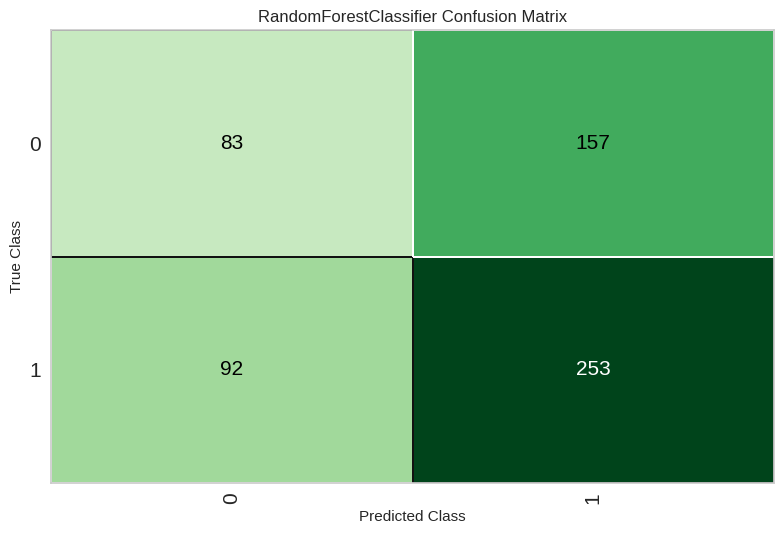

In [86]:
plot_model(rf_cat, "confusion_matrix")

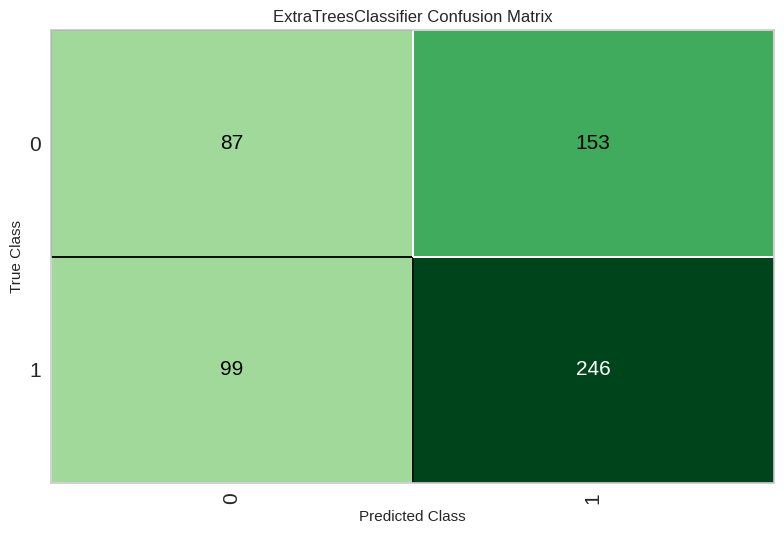

In [80]:
plot_model(et_cat, "confusion_matrix")

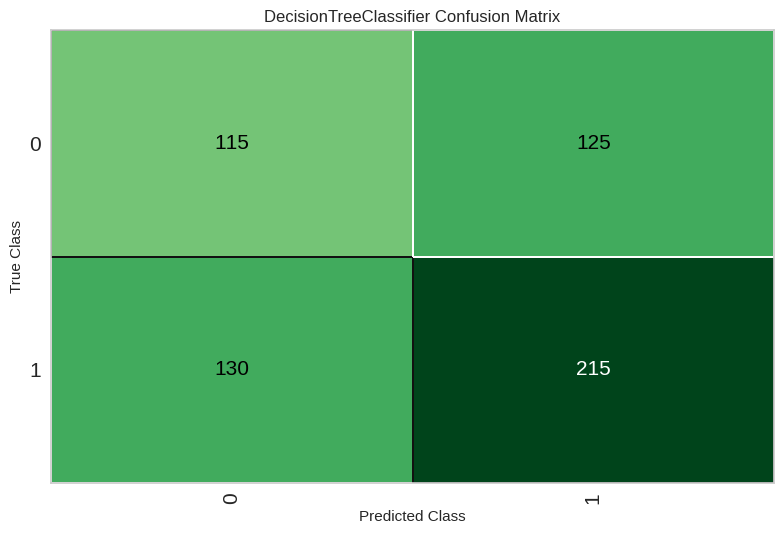

In [81]:
plot_model(dt_cat, "confusion_matrix")

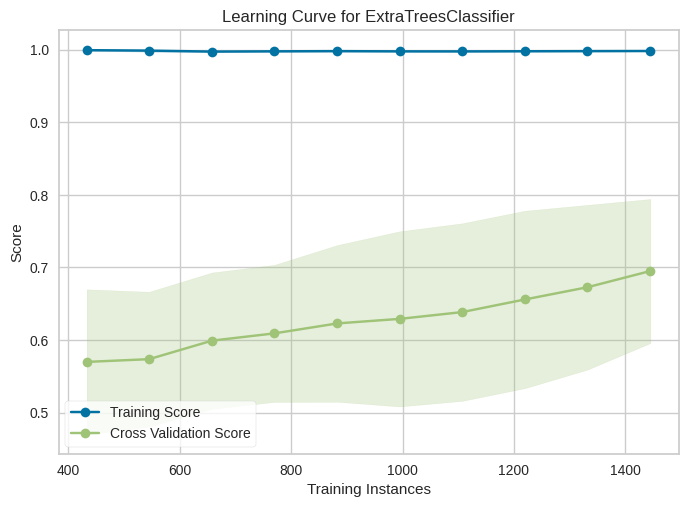

In [82]:
plot_model(et_cat, "learning")

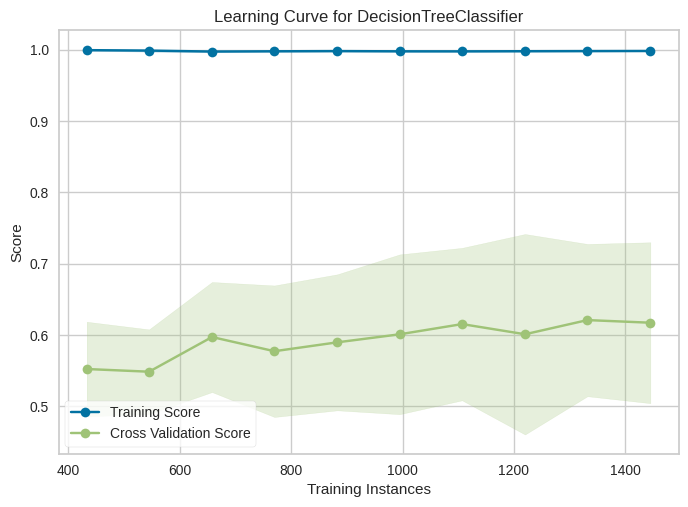

In [83]:
plot_model(dt_cat, "learning")

In [84]:
blended_cat = blend_models([et_cat, dt_cat])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5912,0.5929,0.6790,0.6471,0.6627,0.1449,0.1452
1,0.5255,0.5290,0.6543,0.5889,0.6199,-0.0066,-0.0066
2,0.4964,0.5040,0.5556,0.5769,0.5660,-0.0335,-0.0335
3,0.5441,0.5679,0.6125,0.6125,0.6125,0.0589,0.0589
4,0.5662,0.6170,0.6125,0.6364,0.6242,0.1116,0.1117
5,0.5147,0.5612,0.5875,0.5875,0.5875,-0.0018,-0.0018
6,0.5515,0.5746,0.6125,0.6203,0.6164,0.0766,0.0766
7,0.6324,0.6768,0.7000,0.6829,0.6914,0.2370,0.2371
8,0.5588,0.5979,0.6375,0.6220,0.6296,0.0844,0.0844


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [85]:
blended_cat_tuned = tune_model(blended_cat)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6350,0.6017,0.7654,0.6667,0.7126,0.2191,0.2231
1,0.5912,0.5394,0.7778,0.6238,0.6923,0.1050,0.1108
2,0.5255,0.5141,0.6173,0.5952,0.6061,0.0102,0.0102
3,0.5441,0.5661,0.6625,0.6023,0.6310,0.0383,0.0386
4,0.5956,0.6277,0.7000,0.6437,0.6707,0.1492,0.1501
5,0.5809,0.5788,0.6750,0.6353,0.6545,0.1231,0.1234
6,0.5809,0.5647,0.7125,0.6264,0.6667,0.1086,0.1102
7,0.6176,0.6710,0.7375,0.6556,0.6941,0.1890,0.1913
8,0.5882,0.6023,0.7000,0.6364,0.6667,0.1314,0.1324


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [87]:
blended_cat2 = blend_models([rf_cat, dt_cat])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5912,0.5861,0.6790,0.6471,0.6627,0.1449,0.1452
1,0.5255,0.5525,0.6543,0.5889,0.6199,-0.0066,-0.0066
2,0.4964,0.5144,0.5556,0.5769,0.5660,-0.0335,-0.0335
3,0.5441,0.5789,0.6125,0.6125,0.6125,0.0589,0.0589
4,0.5662,0.5872,0.6125,0.6364,0.6242,0.1116,0.1117
5,0.5074,0.5799,0.5875,0.5802,0.5839,-0.0197,-0.0197
6,0.5515,0.5850,0.6125,0.6203,0.6164,0.0766,0.0766
7,0.6324,0.7015,0.7000,0.6829,0.6914,0.2370,0.2371
8,0.5588,0.6033,0.6375,0.6220,0.6296,0.0844,0.0844


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [88]:
blended_cat2_tuned = tune_model(blended_cat2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6058,0.5953,0.7284,0.6484,0.6860,0.1614,0.1634
1,0.5693,0.5653,0.7531,0.6100,0.6740,0.0598,0.0627
2,0.5328,0.5241,0.6296,0.6000,0.6145,0.0227,0.0228
3,0.5735,0.5829,0.6875,0.6250,0.6548,0.1004,0.1011
4,0.6029,0.5885,0.7125,0.6477,0.6786,0.1624,0.1637
5,0.5515,0.5864,0.6625,0.6092,0.6347,0.0564,0.0567
6,0.5588,0.5846,0.6625,0.6163,0.6386,0.0744,0.0747
7,0.6618,0.7006,0.7750,0.6889,0.7294,0.2826,0.2861
8,0.5882,0.6054,0.6750,0.6429,0.6585,0.1408,0.1411


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [89]:
rf_cat_holdout = predict_model(rf_cat)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.5744,0.5721,0.7333,0.6171,0.6702,0.0826,0.0850


In [90]:
pred_train_rf_cat = predict_model(rf_cat, data=ltv_train)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8706,0.9572,0.9172,0.8702,0.8931,0.7296,0.7312


In [91]:
pred_test_rf_cat = predict_model(rf_cat, data=ltv_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.5925,0.5931,0.6895,0.6741,0.6817,0.1157,0.1157


In [92]:
pred_train_rf_cat["ltv_mpa_ratio"] = (
  pred_train_rf_cat["Customer Lifetime Value"] - 600)/(
      pred_train_rf_cat["Monthly Premium Auto"])

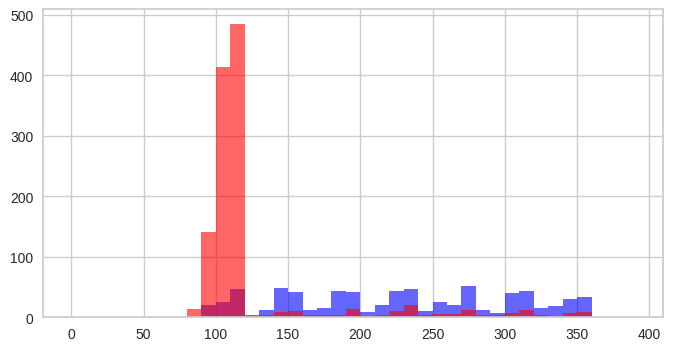

In [93]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(pred_train_rf_cat[
    pred_train_rf_cat["prediction_label"]==0]["ltv_mpa_ratio"],
        bins=np.arange(0, 400, 10),
        alpha=.6, color="blue")
ax.hist(pred_train_rf_cat[
    pred_train_rf_cat["prediction_label"]==1]["ltv_mpa_ratio"],
        bins=np.arange(0, 400, 10),
        alpha=.6, color="red")
plt.show()

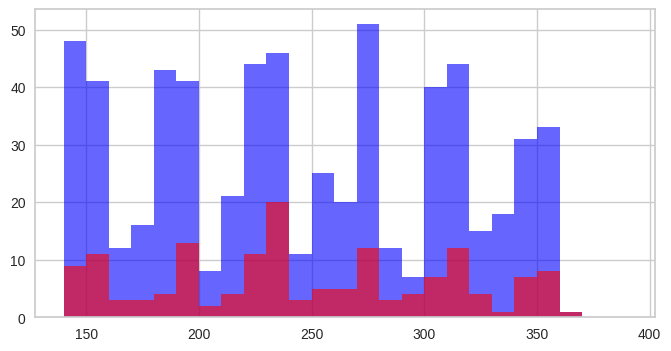

In [94]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(pred_train_rf_cat[
    pred_train_rf_cat["prediction_label"]==0]["ltv_mpa_ratio"],
        bins=np.arange(140, 400, 10),
        alpha=.6, color="blue")
ax.hist(pred_train_rf_cat[
    pred_train_rf_cat["prediction_label"]==1]["ltv_mpa_ratio"],
        bins=np.arange(140, 400, 10),
        alpha=.6, color="red")
plt.show()

continuous input only

In [95]:
list(ltv_train)

['Customer',
 'State',
 'Customer Lifetime Value',
 'Response',
 'Coverage',
 'Education',
 'Effective To Date',
 'EmploymentStatus',
 'Gender',
 'Income',
 'Location Code',
 'Marital Status',
 'Monthly Premium Auto',
 'Months Since Last Claim',
 'Months Since Policy Inception',
 'Number of Open Complaints',
 'Number of Policies',
 'Policy Type',
 'Policy',
 'Renew Offer Type',
 'Sales Channel',
 'Total Claim Amount',
 'Vehicle Class',
 'Vehicle Size',
 'Policy Level',
 'vehicle class group',
 'Is_Tier_3']

In [96]:
ltv_numr_models = setup(
    data=ltv_train, target = "Is_Tier_3", fix_imbalance=True,
    ignore_features=[
        'Customer', 'Customer Lifetime Value', 'Customer', 'State',
        'Customer Lifetime Value', 'Response', 'Coverage', 'Education',
        'EmploymentStatus', 'Gender', 'Location Code',
        'Marital Status','Policy Type', 'Policy', 'Renew Offer Type',
        'Sales Channel','Vehicle Class', 'Vehicle Size', 'Policy Level',
        'vehicle class group',], session_id=123)

,Description,Value
0,Session id,123
1,Target,Is_Tier_3
2,Target type,Binary
3,Original data shape,"(1948, 27)"
4,Transformed data shape,"(2191, 9)"
5,Transformed train set shape,"(1606, 9)"
6,Transformed test set shape,"(585, 9)"
7,Ignore features,20
8,Numeric features,8
9,Preprocess,True


In [97]:
best_numr_model = compare_models(fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.5936,0.6232,0.6800,0.6478,0.6635,0.1513,0.1516,0.3760
et,Extra Trees Classifier,0.5819,0.6191,0.6789,0.6350,0.6556,0.1242,0.1254,0.2960
lightgbm,Light Gradient Boosting Machine,0.5665,0.5920,0.6539,0.6268,0.6397,0.0958,0.0960,1.2960
knn,K Neighbors Classifier,0.5650,0.5644,0.5940,0.6421,0.6166,0.1151,0.1160,0.1260
dt,Decision Tree Classifier,0.5649,0.5540,0.6151,0.6367,0.6252,0.1065,0.1068,0.0780
gbc,Gradient Boosting Classifier,0.5635,0.5696,0.6177,0.6327,0.6244,0.1030,0.1034,0.2640
xgboost,Extreme Gradient Boosting,0.5613,0.5799,0.6302,0.6275,0.6287,0.0926,0.0926,0.1520
ada,Ada Boost Classifier,0.5583,0.5495,0.6077,0.6301,0.6182,0.0944,0.0947,0.1720
lr,Logistic Regression,0.5502,0.5453,0.5827,0.6274,0.6039,0.0850,0.0854,1.0880
ridge,Ridge Classifier,0.5312,0.0000,0.5404,0.6168,0.5751,0.0567,0.0575,0.0660


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [99]:
rf_numr = create_model("rf")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6496,0.6775,0.8148,0.6667,0.7333,0.2373,0.2476
1,0.5693,0.5894,0.6667,0.6279,0.6467,0.0966,0.0969
2,0.5255,0.5518,0.5926,0.6000,0.5963,0.0211,0.0211
3,0.6250,0.6785,0.6875,0.6790,0.6832,0.2238,0.2238
4,0.5221,0.5608,0.5625,0.6000,0.5806,0.0264,0.0265
5,0.5515,0.5797,0.6250,0.6173,0.6211,0.0716,0.0716
6,0.5515,0.5666,0.5875,0.6267,0.6065,0.0863,0.0866
7,0.5735,0.6440,0.6500,0.6341,0.6420,0.1149,0.1150
8,0.6250,0.6761,0.7125,0.6706,0.6909,0.2154,0.2160


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [100]:
rf_numr_tuned = tune_model(rf_numr)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5255,0.5287,0.6173,0.5952,0.6061,0.0102,0.0102
1,0.5474,0.5481,0.6543,0.6092,0.6310,0.0480,0.0482
2,0.4891,0.5123,0.4444,0.5902,0.5070,-0.0019,-0.0020
3,0.5809,0.6596,0.5750,0.6667,0.6174,0.1596,0.1617
4,0.4853,0.4815,0.5375,0.5658,0.5513,-0.0512,-0.0513
5,0.5662,0.5558,0.5125,0.6721,0.5816,0.1478,0.1537
6,0.5147,0.5281,0.4875,0.6094,0.5417,0.0394,0.0405
7,0.6397,0.6699,0.7375,0.6782,0.7066,0.2420,0.2435
8,0.5956,0.6203,0.6000,0.6761,0.6358,0.1848,0.1865


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


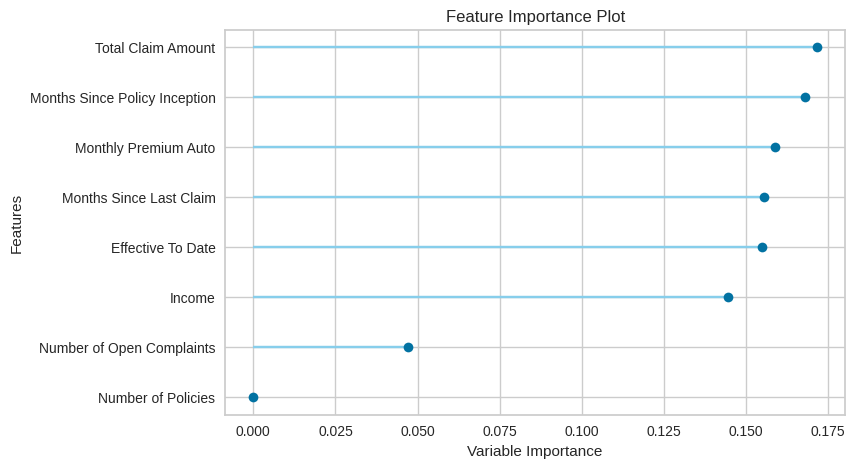

In [101]:
plot_model(rf_numr, plot="feature")

In [102]:
rf_cat_numr_blend = blend_models([rf_cat, rf_numr])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6496,0.6775,0.8148,0.6667,0.7333,0.2373,0.2476
1,0.5693,0.5894,0.6667,0.6279,0.6467,0.0966,0.0969
2,0.5255,0.5518,0.5926,0.6000,0.5963,0.0211,0.0211
3,0.6250,0.6785,0.6875,0.6790,0.6832,0.2238,0.2238
4,0.5221,0.5608,0.5625,0.6000,0.5806,0.0264,0.0265
5,0.5515,0.5797,0.6250,0.6173,0.6211,0.0716,0.0716
6,0.5515,0.5666,0.5875,0.6267,0.6065,0.0863,0.0866
7,0.5735,0.6440,0.6500,0.6341,0.6420,0.1149,0.1150
8,0.6250,0.6761,0.7125,0.6706,0.6909,0.2154,0.2160


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [103]:
rf_cat_numr_blend_tuned = tune_model(rf_cat_numr_blend)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6496,0.6775,0.8148,0.6667,0.7333,0.2373,0.2476
1,0.5693,0.5894,0.6667,0.6279,0.6467,0.0966,0.0969
2,0.5255,0.5518,0.5926,0.6000,0.5963,0.0211,0.0211
3,0.6250,0.6785,0.6875,0.6790,0.6832,0.2238,0.2238
4,0.5221,0.5608,0.5625,0.6000,0.5806,0.0264,0.0265
5,0.5515,0.5797,0.6250,0.6173,0.6211,0.0716,0.0716
6,0.5515,0.5666,0.5875,0.6267,0.6065,0.0863,0.0866
7,0.5735,0.6440,0.6500,0.6341,0.6420,0.1149,0.1150
8,0.6250,0.6761,0.7125,0.6706,0.6909,0.2154,0.2160


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [104]:
pred_holdout_brf = predict_model(rf_cat_numr_blend)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.5778,0.6314,0.6522,0.6392,0.6456,0.1236,0.1236


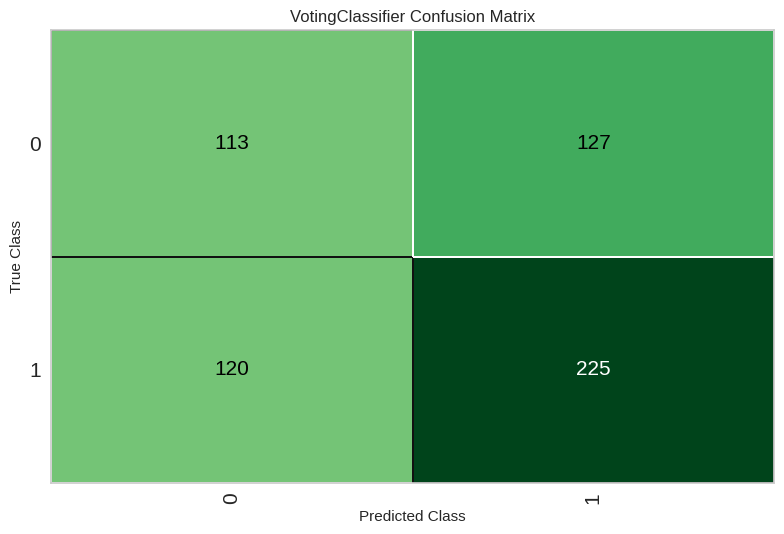

In [105]:
plot_model(rf_cat_numr_blend, plot="confusion_matrix")